Сначала импортируем всякое дерьио

In [1]:
import os
import random
import statistics
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

И функцию для подсчёта дискретной производной 4мя способами

In [2]:
from utils import compute_diffs

Создаём папки для сохранения промежуточных резултатов

In [3]:
save_dir_path = str(Path().absolute()) + '/mean/'
if not os.path.exists(save_dir_path):
   os.makedirs(save_dir_path)

save_dir_path = str(Path().absolute()) + '/roi1/'
if not os.path.exists(save_dir_path):
   os.makedirs(save_dir_path)

save_dir_path = str(Path().absolute()) + '/roi2/'
if not os.path.exists(save_dir_path):
   os.makedirs(save_dir_path)

save_dir_path = str(Path().absolute()) + '/roi3/'
if not os.path.exists(save_dir_path):
   os.makedirs(save_dir_path)

save_dir_path = str(Path().absolute()) + '/plots/'
if not os.path.exists(save_dir_path):
   os.makedirs(save_dir_path)

Массив значений фокусной дистанции

In [4]:
f_distances = [0.4, 0.5, 0.6, 0.7, 0.8, 1, 1.2, 1.5, 2, 4, 8, 'Бесконечность']

Усреднение 10-ти фотографий и поиск среднекрадратичного отклонения

In [5]:
for f_dist in f_distances:
    # load images
    dir_path = str(Path().absolute()) + '/' + str(f_dist)

    images_paths = [dir_path + '/' + path for path in os.listdir(dir_path)]
    images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in images_paths]
    
    images_num = len(images)
    assert(images_num == 10)

    # mean of images
    images_mean = images[0]
    for i in range(1, images_num):
        alpha = 1.0/(i + 1)
        beta = 1.0 - alpha
        images_mean = cv2.addWeighted(images[i], alpha, images_mean, beta, 0.0)

    cv2.imwrite(str(Path().absolute()) + '/mean/' + str(f_dist) + '.png', images_mean)

    # std of image
    image_std = 0.0
    for i in range(0, images_num):
        image_cur = images[i].astype(float) / 255.0
        image_std += ((image_cur[:,:] - images_mean)**2).sum() / (image_cur.shape[0]*image_cur.shape[1])
    
    image_std = np.sqrt(image_std/images_num)
    print('Std (' + str(f_dist) + ') = ' + str(image_std))

Std (0.4) = 86.94465453491149
Std (0.5) = 90.46290542143056
Std (0.6) = 88.43902136061469
Std (0.7) = 130.5110190628121
Std (0.8) = 89.1930803783722
Std (1) = 72.1909509871738
Std (1.2) = 72.90112358765882
Std (1.5) = 66.39843397518673
Std (2) = 134.11244799283932
Std (4) = 66.66415359199068
Std (8) = 66.31335816226444
Std (Бесконечность) = 65.96681239123812


Вырезание фрагментов изображения для дальнейшей обработки

In [6]:
for f_dist in f_distances:
    image = cv2.imread(str(Path().absolute()) + '/mean/' + str(f_dist) + '.png')

    # крупные детали
    x, y, w, h = (430, 600, 600, 400)
    image_roi = image[y:y+h,x:x+w]
    cv2.imwrite(str(Path().absolute()) + '/roi1/' + str(f_dist) + '.png', image_roi)

    # мелкие детали
    x, y, h, w = (400, 40, 400, 400)
    image_roi = image[y:y+h,x:x+w]
    cv2.imwrite(str(Path().absolute()) + '/roi2/' + str(f_dist) + '.png', image_roi)

    # крупные и мелкие детали
    x, y, h, w = (40, 40, 400, 400)
    image_roi = image[y:y+h,x:x+w]
    cv2.imwrite(str(Path().absolute()) + '/roi3/' + str(f_dist) + '.png', image_roi)

Нахождение производных

In [7]:
diffs, row_diffs, col_diffs, all_diffs = [], [], [], []
t1, t2, t3, t4 = [], [], [], []
for roi_dir in ['/roi1', '/roi2', '/roi3']:
    dir_path = str(Path().absolute()) + roi_dir

    roi_diffs, roi_row_diffs, roi_col_diffs, roi_all_diffs = [], [], [], []
    for f_dist in f_distances:
        image_path = dir_path + '/' + str(f_dist) + '.png'
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        ([diff, row_diff, col_diff, all_diff], [t1_, t2_, t3_, t4_ ]) = compute_diffs(image=image)

        roi_diffs.append(diff)
        roi_row_diffs.append(row_diff)
        roi_col_diffs.append(col_diff)
        roi_all_diffs.append(all_diff)
        t1.append(t1_)
        t2.append(t2_)
        t3.append(t3_)
        t4.append(t4_)

    diffs.append(roi_diffs)
    row_diffs.append(roi_row_diffs)
    col_diffs.append(roi_col_diffs)
    all_diffs.append(roi_all_diffs)

Затраченное время:

In [8]:
print("1 mean time = " + str(statistics.median(t1)))
print("2 mean time = " + str(statistics.median(t2)))
print("3 mean time = " + str(statistics.median(t3)))
print("4 mean time = " + str(statistics.median(t4)))

1 mean time = 0.0002974271774291992
2 mean time = 0.029421210289001465
3 mean time = 0.029739856719970703
4 mean time = 0.05923271179199219


График детальности изображений в зависимости от фокусной дистанции

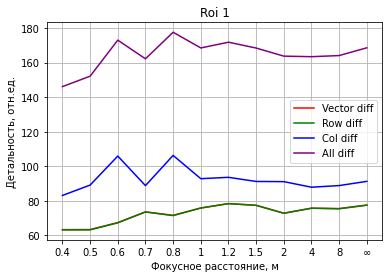

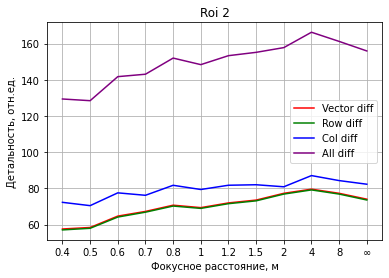

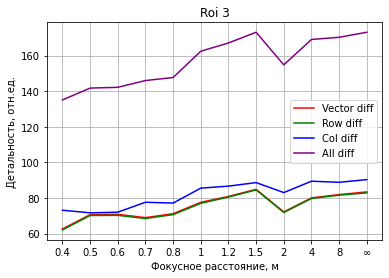

In [9]:
x_ = range(len(f_distances))
f_distances_labels = [str(i) for i in f_distances]
f_distances_labels[11] = '∞'
for i in range(3):
    #fig, ax = plt.subplots()
    #fig.canvas.draw()
    plt.plot(x_, diffs[i], 'r', x_, row_diffs[i], 'g', x_, col_diffs[i], 'b', x_, all_diffs[i], 'purple')
    plt.xticks(x_, f_distances_labels)
    plt.ylabel('Детальность, отн.ед.')
    plt.xlabel('Фокусное расстояние, м')
    plt.title(f'Roi {i+1}')
    plt.grid(True)
    plt.legend(['Vector diff', 'Row diff', 'Col diff', 'All diff'])
    plt.savefig(str(Path().absolute()) + '/plots/roi' + str(i + 1) + '.png')
    plt.show()
    plt.close()

Мега харош время подсчёта производной от количества пикселей

In [10]:
random.seed()
f_dist = f_distances[random.randint(0, len(f_distances) - 1) ]
image = cv2.imread(str(Path().absolute()) + '/mean/' + str(f_dist) + '.png', cv2.IMREAD_GRAYSCALE)

height = image.shape[0]
width = image.shape[1]

t1, t2, t3, t4 = [], [], [], []
roi_percent = []
N = 15
for i in range(1, N + 1):
    w = int(width / i)
    h = int(height / i)
    x, y = (int(width/2 - w/2), int(height/2 - h/2))
    image_roi = image[y:y+h,x:x+w]

    roi_percent.append(int((N - i + 1) / N * 100))

    ([diff, row_diff, col_diff, all_diff], [t1_, t2_, t3_, t4_ ]) = compute_diffs(image=image_roi)
    t1.append(t1_)
    t2.append(t2_)
    t3.append(t3_)
    t4.append(t4_)

Строим график

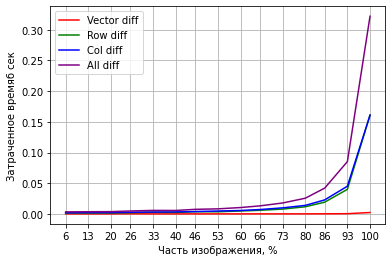

In [14]:
x_labels = [str(i) for i in roi_percent]
plt.plot(roi_percent, t1, 'r', roi_percent, t2, 'g', roi_percent, t3, 'b', roi_percent, t4, 'purple')
plt.xticks(roi_percent, x_labels)
plt.ylabel('Затраченное времяб сек')
plt.xlabel('Часть изображения, %')
plt.grid(True)
plt.legend(['Vector diff', 'Row diff', 'Col diff', 'All diff'])
plt.savefig(str(Path().absolute()) + '/plots/elapsed_time.png')